# Proyek Klasifikasi Gambar
- **Nama:** Ayudha Kusuma Rahmadhani
- **Email:** deuxyudha@gmail.com

#  Sumber Dataset

Dataset  Animal kaggle (https://www.kaggle.com/datasets/shiv28/animal-5-mammal).

## Import Packages/Library yang Digunakan

In [2]:
!pip install tensorflowjs

from pathlib import Path
from shutil import copy2
from zipfile import ZipFile

import gdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## Data Preparation

In [4]:
# Mendownload dataset
url = "https://drive.google.com/uc?id=1LNTLv01Bd_8vvKUUdjdLEEQa1DXTn4lK"
output = "animal-5-mammal.zip"

if Path(output).exists():
    print("File already exists, skipping download:", output)
else:
    gdown.download(url, output)
    print("Downloaded:", output)

File already exists, skipping download: animal-5-mammal.zip


In [5]:
zip_path = Path(output)
extract_path = Path("dataset")
extract_path.mkdir(parents=True, exist_ok=True)

with ZipFile(zip_path, "r") as zip_file:
    zip_file.extractall(extract_path)

print(f"{zip_path.name} extracted to {extract_path}")

# Show directory structure of dataset

def ascii_tree_dir(path: Path, prefix=""):
    folders = [p for p in sorted(path.iterdir()) if p.is_dir()]
    for i, folder in enumerate(folders):
        connector = "└── " if i == len(folders) - 1 else "├── "
        print(prefix + connector + folder.name + "/")
        extension = "    " if i == len(folders) - 1 else "│   "
        ascii_tree_dir(folder, prefix + extension)

def show_directory_structure(path: Path):
    if path.is_dir():
        print(path.name + "/")
        ascii_tree_dir(path)

show_directory_structure(extract_path)

animal-5-mammal.zip extracted to dataset
dataset/
└── Animal/
    ├── train/
    │   ├── ELEPHANT/
    │   ├── HORSE/
    │   ├── LION/
    │   ├── cat/
    │   └── dog/
    └── val/
        ├── ELEPHANT/
        ├── HORSE/
        ├── LION/
        ├── cat/
        └── dog/


In [6]:
# Create dataframe from dataset

def dir_to_dataframe(dir_path: Path):
    records = []
    for subfolder in dir_path.iterdir():
        if subfolder.is_dir():
            for file in subfolder.iterdir():
                if file.is_file():
                    try:
                        with Image.open(file) as img:
                            img.verify()
                            records.append({
                                "filename": file.name,
                                "class": subfolder.name.lower(),
                                "width": img.width,
                                "height": img.height,
                                "path": str(file.absolute())
                            })
                    except Exception as e:
                        pass
    return pd.DataFrame(records)

train_dir_df = dir_to_dataframe(extract_path.joinpath("Animal/train"))
val_dir_df = dir_to_dataframe(extract_path.joinpath("Animal/val"))

print(f"Train dir: {train_dir_df.shape[0]} images")
print(f"Val dir: {val_dir_df.shape[0]} images")

# Combine images to a directory

combined_dir_path = Path("dataset/combined")

for class_name in train_dir_df["class"].unique():
    combined_dir_path.joinpath(class_name).mkdir(parents=True, exist_ok=True)

train_dir_df.apply(lambda x: copy2(x["path"], combined_dir_path.joinpath(x["class"])), axis=1)
val_dir_df.apply(lambda x: copy2(x["path"], combined_dir_path.joinpath(x["class"])), axis=1)

show_directory_structure(extract_path)

combined_dir_df = dir_to_dataframe(combined_dir_path)
print(f"Combined dir: {combined_dir_df.shape[0]} images")
combined_dir_df

Train dir: 13496 images
Val dir: 1500 images
dataset/
├── Animal/
│   ├── train/
│   │   ├── ELEPHANT/
│   │   ├── HORSE/
│   │   ├── LION/
│   │   ├── cat/
│   │   └── dog/
│   └── val/
│       ├── ELEPHANT/
│       ├── HORSE/
│       ├── LION/
│       ├── cat/
│       └── dog/
└── combined/
    ├── cat/
    ├── dog/
    ├── elephant/
    ├── horse/
    └── lion/
Combined dir: 14996 images


,filename,class,width,height,path
0,pixabay_dog_001898.jpg,dog,512,512,/content/dataset/combined/dog/pixabay_dog_0018...
1,pixabay_dog_000384.jpg,dog,512,512,/content/dataset/combined/dog/pixabay_dog_0003...
2,pixabay_dog_003982.jpg,dog,512,512,/content/dataset/combined/dog/pixabay_dog_0039...
3,pixabay_dog_001520.jpg,dog,512,512,/content/dataset/combined/dog/pixabay_dog_0015...
4,pixabay_dog_002555.jpg,dog,512,512,/content/dataset/combined/dog/pixabay_dog_0025...
...,...,...,...,...,...
14991,pixabay_cat_003522.jpg,cat,512,512,/content/dataset/combined/cat/pixabay_cat_0035...
14992,pixabay_cat_003974.jpg,cat,512,512,/content/dataset/combined/cat/pixabay_cat_0039...
14993,pixabay_cat_002513.jpg,cat,512,512,/content/dataset/combined/cat/pixabay_cat_0025...
14994,pixabay_cat_003094.jpg,cat,512,512,/content/dataset/combined/cat/pixabay_cat_0030...


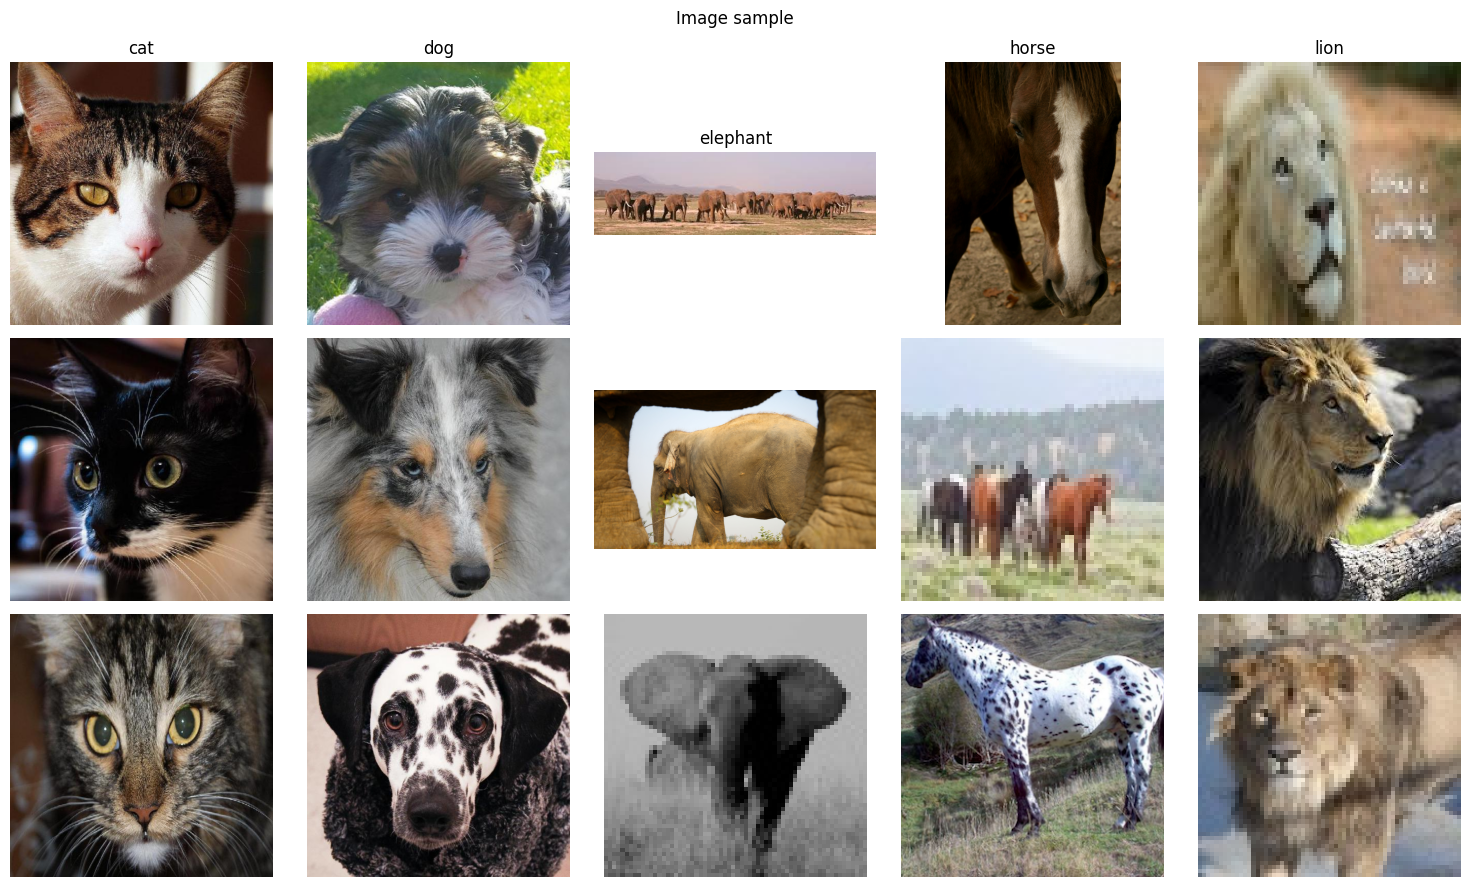

In [7]:
# Plot image sample from each class

n_sample = 3
sample_df = (
    combined_dir_df.groupby("class")[['class','path']]
      .apply(lambda x: x.sample(n=n_sample, random_state=7))
      .reset_index(drop=True)
)

classes = sample_df["class"].unique()
num_classes = len(classes)

plt.figure(figsize=(num_classes * 3, n_sample * 3))
for class_idx, class_name in enumerate(classes):
    class_samples = sample_df[sample_df["class"] == class_name]
    for i, row in enumerate(class_samples.itertuples()):
        plt.subplot(n_sample, num_classes, i * num_classes + class_idx + 1)
        plt.imshow(Image.open(row.path))
        plt.axis("off")
        if i == 0:
            plt.title(class_name)
plt.suptitle("Image sample")
plt.tight_layout()
plt.show()

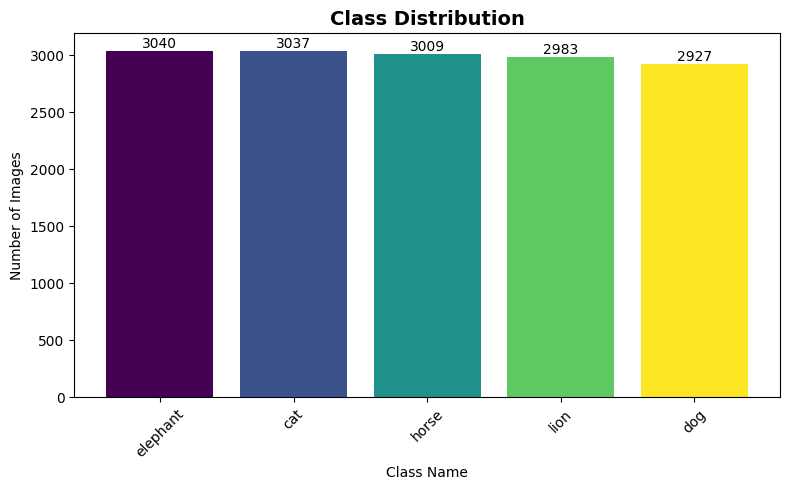

In [8]:
# Plot class distribution

class_counts = combined_dir_df["class"].value_counts()

plt.figure(figsize=(8, 5))

# Buat warna gradasi otomatis
colors = plt.cm.viridis(np.linspace(0, 1, len(class_counts)))

bars = plt.bar(class_counts.index, class_counts.values, color=colors)

plt.title("Class Distribution", fontsize=14, weight="bold")
plt.xlabel("Class Name")
plt.ylabel("Number of Images")

# Tambahkan label jumlah
for i, value in enumerate(class_counts.values):
    plt.text(i, value, str(value), ha="center", va="bottom")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

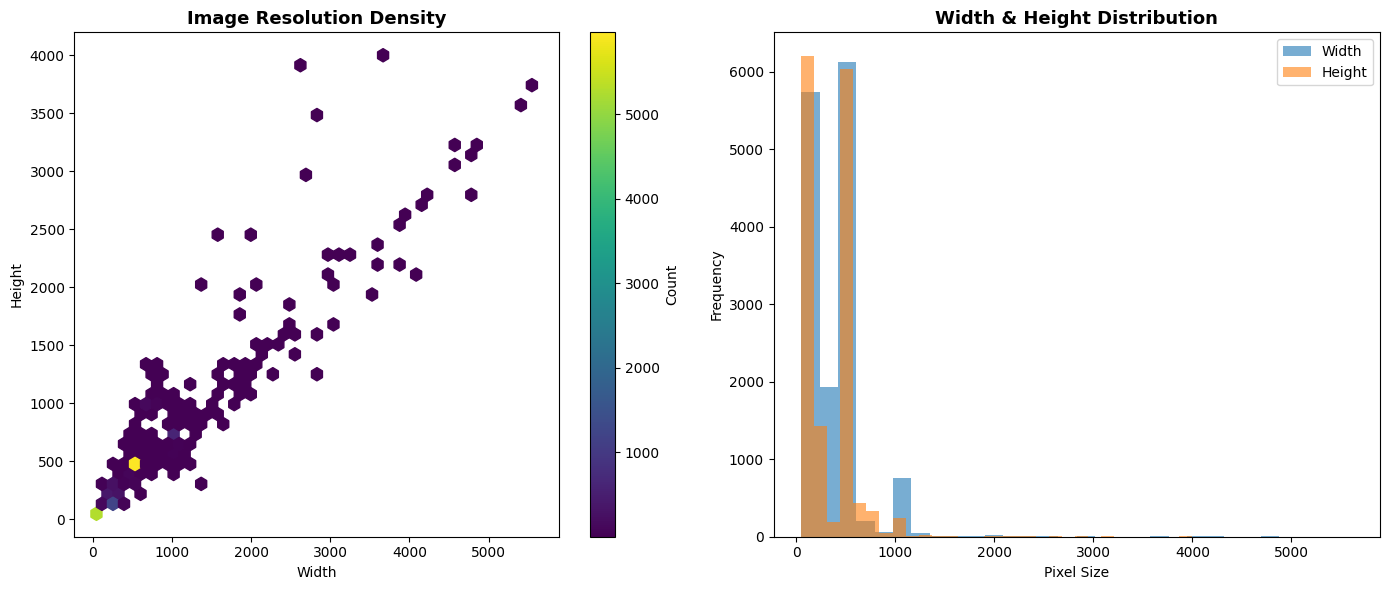

In [9]:
plt.figure(figsize=(14, 6))

# ===============================
# 1️⃣ Hexbin Density Plot
# ===============================
plt.subplot(1, 2, 1)

hb = plt.hexbin(
    combined_dir_df["width"],
    combined_dir_df["height"],
    gridsize=40,
    cmap="viridis",
    mincnt=1
)

plt.colorbar(hb, label="Count")
plt.title("Image Resolution Density", fontsize=13, weight="bold")
plt.xlabel("Width")
plt.ylabel("Height")
plt.grid(False)


# ===============================
# 2️⃣ Histogram Overlay
# ===============================
plt.subplot(1, 2, 2)

plt.hist(
    combined_dir_df["width"],
    bins=30,
    alpha=0.6,
    label="Width"
)

plt.hist(
    combined_dir_df["height"],
    bins=30,
    alpha=0.6,
    label="Height"
)

plt.title("Width & Height Distribution", fontsize=13, weight="bold")
plt.xlabel("Pixel Size")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()


## Data Preprocessing

In [10]:
N_CLASS = combined_dir_df["class"].nunique()
SEED = 80
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 32
IMG_CHANNEL = 3
COLOR_MODE = {1: "grayscale", 3: "rgb"}

# Split dataset

train_df, temp_df = train_test_split(combined_dir_df, test_size=0.1, stratify=combined_dir_df["class"], random_state=SEED)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["class"], random_state=SEED)

print(f"Train size: {train_df.shape[0]} images. {train_df.shape[0]/combined_dir_df.shape[0]*100:.2f}% of the dataset.")
print(f"Val size: {val_df.shape[0]} images. {val_df.shape[0]/combined_dir_df.shape[0]*100:.2f}% of the dataset.")
print(f"Test size: {test_df.shape[0]} images. {test_df.shape[0]/combined_dir_df.shape[0]*100:.2f}% of the dataset.")

# Normalization and augmentation data

datagen = ImageDataGenerator(rescale=1./255)

augment_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

train_gen = augment_datagen.flow_from_dataframe(dataframe=train_df,
                                            x_col="path",
                                            y_col="class",
                                            batch_size=BATCH_SIZE,
                                            target_size=(IMG_WIDTH, IMG_HEIGHT),
                                            color_mode=COLOR_MODE[IMG_CHANNEL],
                                            class_mode='categorical',
                                            shuffle=True,
                                            seed=SEED
                                            )

val_gen = datagen.flow_from_dataframe(dataframe=val_df,
                                            x_col="path",
                                            y_col="class",
                                            batch_size=BATCH_SIZE,
                                            target_size=(IMG_WIDTH, IMG_HEIGHT),
                                            color_mode=COLOR_MODE[IMG_CHANNEL],
                                            class_mode='categorical',
                                            shuffle=False,
                                            )

test_gen= datagen.flow_from_dataframe(dataframe=test_df,
                                            x_col="path",
                                            y_col="class",
                                            batch_size=1,
                                            target_size=(IMG_WIDTH, IMG_HEIGHT),
                                            color_mode=COLOR_MODE[IMG_CHANNEL],
                                            class_mode='categorical',
                                            shuffle=False,
                                            )

Train size: 13496 images. 90.00% of the dataset.
Val size: 750 images. 5.00% of the dataset.
Test size: 750 images. 5.00% of the dataset.
Found 13496 validated image filenames belonging to 5 classes.
Found 750 validated image filenames belonging to 5 classes.
Found 750 validated image filenames belonging to 5 classes.


## Modelling

In [11]:
tf.keras.backend.clear_session()

# Base model (pretrained on ImageNet)
base_model = MobileNetV2(
    input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNEL),
    include_top=False,
    weights='imagenet'
)

# Freeze base
base_model.trainable = False

model = models.Sequential([
    base_model,

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(N_CLASS, activation='softmax')
])

model.summary()

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
]

history = model.fit(
    train_gen,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=val_gen,
    callbacks=callbacks
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 64)       │       737,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,087,109 (11.78 MB)

 Trainable params: 828,741 (3.16 MB)

 Non-trainable params: 2,258,368 (8.61 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 243s 525ms/step - accuracy: 0.8420 - loss: 0.4234 - val_accuracy: 0.9173 - val_loss: 0.2163 - learning_rate: 0.0010
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 191s 452ms/step - accuracy: 0.9143 - loss: 0.2233 - val_accuracy: 0.9280 - val_loss: 0.1932 - learning_rate: 0.0010
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 193s 457ms/step - accuracy: 0.9151 - loss: 0.2142 - val_accuracy: 0.9227 - val_loss: 0.1855 - learning_rate: 0.0010
Epoch 4/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 191s 453ms/step - accuracy: 0.9289 - loss: 0.1982 - val_accuracy: 0.9120 - val_loss: 0.2192 - learning_rate: 0.0010
Epoch 5/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 192s 454ms/step - accuracy: 0.9302 - loss: 0.1838 - val_accuracy: 0.9360 - val_loss: 0.1701 - learning_rate: 0.0010
Epoch 6/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 193s 458ms/step - accuracy: 0.9385 - loss: 0.1572 - val_accuracy: 0.9293 - val_loss: 0.1707 - learning_rate: 0.0010
Epoch 7/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 195s 462ms/step - accura

## Evaluasi dan Visualisasi

In [12]:
train_loss, train_accuracy = model.evaluate(train_gen)
val_loss, val_accuracy = model.evaluate(val_gen)
test_loss, test_accuracy = model.evaluate(test_gen)

print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Val Accuracy: {val_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

422/422 ━━━━━━━━━━━━━━━━━━━━ 192s 456ms/step - accuracy: 0.9443 - loss: 0.1475
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.9585 - loss: 0.1309
750/750 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9501 - loss: 0.1316
Train Accuracy: 0.95
Val Accuracy: 0.94
Test Accuracy: 0.95


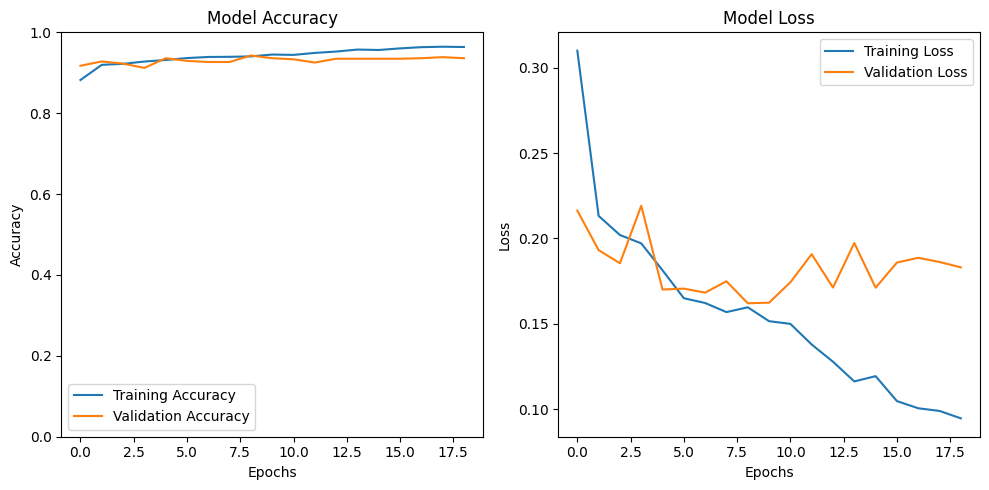

In [13]:
# Visualization

plt.figure(figsize=(10, 5))

# Left plot: Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()

# Right plot: Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Konversi Model

In [14]:
# saved_model format

saved_model_dir = Path("models/saved_model")
saved_model_dir.mkdir(parents=True, exist_ok=True)

model.export("models/saved_model")

Saved artifact at 'models/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  132546162212496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132546162209616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132546162209040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132546162211152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132546162212112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132546162209424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132546162210960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132546162209232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132546162205776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132546162210384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13254616

In [15]:
tflite_dir = Path("models/tflite_model")
tflite_dir.mkdir(parents=True, exist_ok=True)

# 1) Clone model (arsitektur sama)
float32_model = tf.keras.models.clone_model(model)

# 2) Build dulu (penting untuk beberapa versi TF/Keras)
float32_model.build(model.input_shape)

# 3) Copy weights (akan otomatis cast ke float32)
float32_model.set_weights(model.get_weights())

# 4) Convert TFLite dari model float32
converter = tf.lite.TFLiteConverter.from_keras_model(float32_model)

# (opsional) bikin lebih kompatibel
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,     # ops standar
    tf.lite.OpsSet.SELECT_TF_OPS        # fallback jika ada ops TF tertentu
]

tflite_model = converter.convert()

with open(tflite_dir / "model.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ TFLite saved to:", tflite_dir / "model.tflite")

Saved artifact at '/tmp/tmphdc18flo'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  132545848311056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132545848310096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132545848309136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132545848309520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132545848309328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132545848311248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132545848308368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132545848308560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132545848309712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132545848307792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1325458483104

In [16]:
# TensorflowJs format

tfjs_dir = Path("models/tfjs_model")
tfjs_dir.mkdir(parents=True, exist_ok=True)

tfjs.converters.save_keras_model(model, tfjs_dir)

failed to lookup keras version from the file,
    this is likely a weight only file


## Inference (Optional)

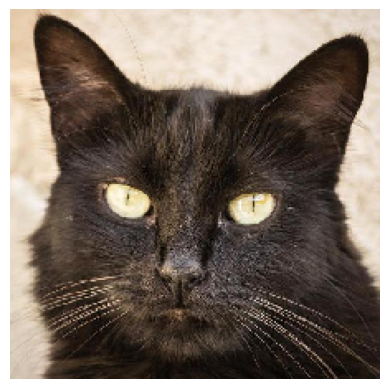

Predictions:
cat: 1.0000
dog: 0.0000
elephant: 0.0000
horse: 0.0000
lion: 0.0000

Predicted class: cat
True class: cat


In [19]:
# Get one image & label from generator
img, label = next(test_gen)

# Show the image
plt.imshow(img[0])
plt.axis("off")
plt.show()

# Build index to class mapping
idx_to_class = {v: k for k, v in test_gen.class_indices.items()}

# Get true class
true_class = idx_to_class[np.argmax(label)]

# Load SavedModel
saved_model = tf.saved_model.load(saved_model_dir)
infer = saved_model.signatures["serving_default"]

# Inference
img_tensor = tf.convert_to_tensor(img)
output = infer(img_tensor)
pred = list(output.values())[0].numpy()[0]

# Print prediction probability with class names
print("Predictions:")
for idx, prob in enumerate(pred):
    print(f"{idx_to_class[idx]}: {prob:.4f}")

# Final results
pred_class = idx_to_class[np.argmax(pred)]
print("\nPredicted class:", pred_class)
print("True class:", true_class)

In [20]:
!pip freeze > /content/requirements.txt